# Use Regression to define weights for each feature

In [3]:
from os import listdir,remove
import numpy as np
from syntax_features import counts
from tqdm import tqdm
import codecs
import pandas as pd
import re

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter

import _pickle as pickle

from feature_extraction import TextFeatureCreator
import spacy


In [4]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [5]:
ts = TextFeatureCreator("data/LSATtexts.txt")

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
HTML_TAG_RE = re.compile('<.*?>')
def remove_html_tags(text):
    return HTML_TAG_RE.sub(' ', text)

In [11]:
path = "data/clean_newsela/"
newsela_path = "data/newsela/"
files = [file for file in listdir(newsela_path) if file[-3:] == "txt"]

## Load Data and define Features

In [12]:
line_break = re.compile(r"(\n|\r|##.*?\r)")
html_tags = re.compile('<.*?>')
dash_lines =  re.compile('-{2,}')
markdown = re.compile('!?\[[^\[]*\]\([^(]+\)')
double_whitespace = re.compile(r"\s+")

def clean_text(text):
    
    regex_expressions = [
        line_break,
        html_tags,
        dash_lines,
        markdown,
        double_whitespace
    ]
    
    for regex_expression in regex_expressions:
        text = regex_expression.sub(" ",text)
    
    return text

In [13]:
test = '"Treasure Island" is by Robert Louis Stevenson. The book tells the story of Jim Hawkins. He works on a sailing ship. In the book, Jim looks for missing treasure. Now, kids can search for the treasure themselves. They can look for it on "Minecraft." Hopefully, it will get kids to read. Litcraft is a new project. It was started by Lancaster University and Microsoft. The university is in England. Microsoft is a giant company. It owns "Minecraft." More than 74 million people play the game each month. "Minecraft" Islands ------------------- Litcraft creates the "Minecraft" islands. They are all based on books. "Treasure Island" was the first one.  Sally Bushell works for Litcraft. She hopes kids will play the game. Then they will want to read the book.  ![Image 2. Litcrafts "Treasure Island." Illustration: Lancaster University.](https://media.newsela.com/article_media/extra/minecrafttreasureisland.jpg) Ms. Bushell said she wished she had the game as a kid. She would have loved it. Players pretend to be the characters. It helps kids understand the books more, she said. Testing New Game ---------------- Children have been testing out the new game.  One of them is Dylan. He is 9 years old and lives in England. He liked reading "Treasure Island." In the "Minecraft" version, he can really explore the island. The game is really fun, he said. Now he knows what the island looks like. He does not have to make it up in his head. Dylans school will use it next year Kids know a lot about "Minecraft." Adults are impressed. They are also a little scared. Many teachers do not know how to play "Minecraft," Ms. Bushell said. On the bright side, they can just ask their students for help.'
clean_text(test)    

'"Treasure Island" is by Robert Louis Stevenson. The book tells the story of Jim Hawkins. He works on a sailing ship. In the book, Jim looks for missing treasure. Now, kids can search for the treasure themselves. They can look for it on "Minecraft." Hopefully, it will get kids to read. Litcraft is a new project. It was started by Lancaster University and Microsoft. The university is in England. Microsoft is a giant company. It owns "Minecraft." More than 74 million people play the game each month. "Minecraft" Islands Litcraft creates the "Minecraft" islands. They are all based on books. "Treasure Island" was the first one. Sally Bushell works for Litcraft. She hopes kids will play the game. Then they will want to read the book. Ms. Bushell said she wished she had the game as a kid. She would have loved it. Players pretend to be the characters. It helps kids understand the books more, she said. Testing New Game Children have been testing out the new game. One of them is Dylan. He is 9 y

In [21]:
def clean_files(root,file_names,new_root):
    
    for file_name in tqdm(file_names):
        with codecs.open(root+file_name, "r",encoding='utf-8', errors='ignore') as f_read:
            text = f_read.read()
            if text.find("This article has been removed") < 0:
                text = clean_text(text)
                with codecs.open(new_root+file_name, "w",encoding='utf-8', errors='ignore') as f_write:
                    f_write.write(text)
            f_read.close()
            f_write.close()

In [22]:
def score_file_text(file_path,cleaning=False):
    with codecs.open(file_path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        if cleaning:
            text = clean_text(text)
        score = ts.norm_features(ts.get_text_features([f.read()]))
        #score[12] = 1 / score[12]
    return score

### Delete Spanish Files

In [5]:
#delete spanish texts
spanish_files = [file for file in files if file[:-4].split("-")[-3] == "spanish"]
for file in spanish_files:
    remove(newsela_path+"/"+file)

### Clean Files

In [16]:
clean_newsela_path = "data/clean_newsela/"

In [23]:
clean_files("data/newsela/",files,"data/clean_newsela/")

100%|██████████| 21501/21501 [00:32<00:00, 662.79it/s]


### Training Newsela

In [96]:
files_with_score = []
for file in files:
    split_file_name = file[:-4].split("-")
    file_name = "-".join(split_file_name[:-2])
    file_id = split_file_name[-2]
    level = split_file_name[-1]
    files_with_score += [(clean_newsela_path+file,file_name,file_id,level)]
files_with_score[:5]

[('data/clean_newsela/nano-silver-2940-1030.txt',
  'nano-silver',
  '2940',
  '1030'),
 ('data/clean_newsela/elem-robot-dog-funeral-japan-42851-970.txt',
  'elem-robot-dog-funeral-japan',
  '42851',
  '970'),
 ('data/clean_newsela/public-schools-confederate-names-34585-830.txt',
  'public-schools-confederate-names',
  '34585',
  '830'),
 ('data/clean_newsela/food-waste-6332-490.txt', 'food-waste', '6332', '490'),
 ('data/clean_newsela/scotus-jerusalem-10579-720.txt',
  'scotus-jerusalem',
  '10579',
  '720')]

In [97]:
lines = []

for path,article_name,file_id,newsela_score in tqdm(files_with_score):
    score = score_file_text(path)
    lines += [np.concatenate([[path,article_name,file_id,newsela_score],score.reshape(-1)])]


100%|██████████| 21501/21501 [15:15:30<00:00,  2.55s/it]   


In [98]:
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["path","name","text","newsela_score"],ts.feature_names]))
df[df.columns[3:]] = df[df.columns[3:]].astype(float)
df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,data/clean_newsela/nano-silver-2940-1030.txt,nano-silver,2940,1030.0,1.019529,0.586412,0.884826,0.581094,0.885181,0.673599,...,0.380605,1.218640,0.483881,0.394310,0.959392,0.0,0.838109,0.640111,0.377311,0.516204
1,data/clean_newsela/elem-robot-dog-funeral-japa...,elem-robot-dog-funeral-japan,42851,970.0,0.915473,0.542635,0.899704,0.508872,0.900190,0.601939,...,0.430961,0.672881,0.243993,1.345911,0.323163,0.0,0.397326,0.512089,0.441730,0.528593
2,data/clean_newsela/public-schools-confederate-...,public-schools-confederate-names,34585,830.0,0.984002,0.440245,0.892342,0.408791,0.794801,0.635107,...,0.200758,0.764637,0.308343,1.201706,0.415496,0.0,0.454087,0.438934,0.323936,0.268072
3,data/clean_newsela/food-waste-6332-490.txt,food-waste,6332,490.0,0.806384,0.335052,1.263972,0.262201,0.877718,0.359253,...,0.144134,0.794046,0.126328,0.000000,0.124294,0.0,0.382044,0.886308,0.130254,0.137231
4,data/clean_newsela/scotus-jerusalem-10579-720.txt,scotus-jerusalem,10579,720.0,0.942516,0.403098,1.179167,0.346986,0.667727,0.510010,...,0.284408,0.819254,0.150820,0.150213,0.403954,0.0,0.567608,0.640111,0.305004,0.198222


### Add ElSAT Text to file

In [99]:
LSAT_score = 1800

copy_df = pd.DataFrame(data=[np.concatenate([["data/LSATtexts.txt","LSAT","0000",LSAT_score],len(ts.feature_names)*[1.0]])],columns=df.columns)
df = df.loc[df["name"] != "LSAT"]
df = pd.concat([df,copy_df])

In [100]:
df[ts.feature_names+["newsela_score"]] = df[ts.feature_names+["newsela_score"]].astype(float)
df["newsela_score"] = df["newsela_score"] / LSAT_score
df.dtypes

path                       object
name                       object
text                       object
newsela_score             float64
Mean word length          float64
Mean sentence length      float64
Basic english ratio       float64
Syllables per sentence    float64
Type token ratio          float64
#nouns                    float64
#verbs                    float64
#adjectives               float64
#adverbs                  float64
#pronouns                 float64
#commas                   float64
Subordination             float64
Complements               float64
Coordination              float64
Apposition                float64
Passive verbs             float64
Parataxis                 float64
Auxiliary Verbs           float64
Negation                  float64
Prepositional Phrases     float64
Modifiers                 float64
dtype: object

In [101]:
df["feature_sums"] = df[ts.feature_names].sum(axis=1)
df["feature_sums"] = pd.to_numeric(df["feature_sums"].values)

In [102]:
df.to_csv("data/newsela_article_features.csv",sep=";",index=False)

### Training Weebit

In [52]:
weebit_folders

['BitGCSE', 'WRLevel4', 'WRLevel3', 'WRLevel2', 'BitKS3']

In [56]:
score_file_text("data/weebit/WeeBit-TextOnly/BitGCSE/3644.txt")

array([[ 0.93033483,  0.53311869,  1.36846326,  0.47243429,  1.23324251,
         0.5688166 ,  0.7257176 ,  0.38850369,  0.61145902,  0.91186384,
         0.06135285,  0.41638788,  1.529274  ,  0.10427069,  1.86932063,
         0.35907052,  0.        ,  0.80936743,  2.8449397 ,  0.42536998,
         0.32302878]])

In [59]:
weebit_root = "data/weebit/WeeBit-TextOnly/"
weebit_folders = listdir(weebit_root)
weebit_folders.remove(".DS_Store")
weebit_folders.remove("weebit_articles.zip")
weebit_data = []
for folder in tqdm(weebit_folders):
    curr_path = weebit_root + folder
    weebit_data += [
        np.concatenate([
            [curr_path,file_name],
            score_file_text(curr_path+"/"+file_name).reshape(-1)]) 
        for file_name in listdir(curr_path)]


100%|██████████| 5/5 [29:42<00:00, 356.46s/it]   


In [65]:
weebit_df = pd.DataFrame(
    data=weebit_data,
    columns=np.concatenate([["path","id"],ts.feature_names]))
for col in ts.feature_names:
    weebit_df[col] = pd.to_numeric(weebit_df[col])
weebit_df["path"] = weebit_df["path"]+"/"+ weebit_df["id"]
weebit_df.head()

,path,id,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,data/weebit/WeeBit-TextOnly/BitGCSE/3644.txt,3644.txt,0.930335,0.533119,1.368463,0.472434,1.233243,0.568817,0.725718,0.388504,...,0.416388,1.529274,0.104271,1.869321,0.359071,0.000000,0.809367,2.844940,0.425370,0.323029
1,data/weebit/WeeBit-TextOnly/BitGCSE/5235.txt,5235.txt,0.954389,0.660137,1.147297,0.631881,1.062349,0.755927,0.557247,0.524480,...,0.312291,1.019516,0.469218,0.934660,0.718141,0.000000,0.625420,0.853482,0.785298,0.543276
2,data/weebit/WeeBit-TextOnly/BitGCSE/1053.txt,1053.txt,0.977443,0.621495,1.041245,0.584637,1.343503,0.848734,0.606493,0.594411,...,0.255511,0.695125,0.682499,3.058888,0.293785,5.405217,0.481607,0.931071,0.481888,0.528593
3,data/weebit/WeeBit-TextOnly/BitGCSE/7422.txt,7422.txt,0.972173,0.568898,1.231246,0.539992,1.001589,0.601748,0.606493,0.815858,...,0.437207,0.917564,0.312812,1.121592,1.292654,0.000000,0.794652,0.682786,0.510444,0.775269
4,data/weebit/WeeBit-TextOnly/BitGCSE/7344.txt,7344.txt,0.966905,0.694639,1.170712,0.672713,1.081696,0.866055,0.899742,0.524480,...,0.936873,0.983105,0.469218,1.201706,1.615817,0.000000,0.898713,1.097334,0.588974,0.641862


In [66]:
#Remove metadata files
weebit_df = weebit_df.loc[weebit_df["id"] != ".DS_Store"]
#Remove Inf value rows
weebit_df = weebit_df.loc[np.isfinite(weebit_df["Basic english ratio"])]

In [67]:
weebit_df.to_csv("data/weebit_articles_features.csv",index=False,sep=";")

## Plot Result

In [70]:
#plot_df = df.loc[df["newsela_score"] != "max"]
#reg_df = df.copy()
#reg_df["newsela_score"] = pd.to_numeric(reg_df["newsela_score"])

In [103]:
#normalize features
norm_df = df.copy()
#newsela_scores = norm_df["newsela_score"]
#norm_df = normalize_cols(norm_df,["newsela_score"])#norm_df[norm_cols] = normalize(plot_df[norm_cols])#(norm_df[norm_cols] - norm_df[norm_cols].mean())/norm_df[norm_cols].std()
#norm_df["newsela_score"] = norm_df["newsela_score"] / norm_df["newsela_score"].max()
norm_df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,data/clean_newsela/nano-silver-2940-1030.txt,nano-silver,2940,0.572222,1.019529,0.586412,0.884826,0.581094,0.885181,0.673599,...,1.218640,0.483881,0.394310,0.959392,0.0,0.838109,0.640111,0.377311,0.516204,13.276822
1,data/clean_newsela/elem-robot-dog-funeral-japa...,elem-robot-dog-funeral-japan,42851,0.538889,0.915473,0.542635,0.899704,0.508872,0.900190,0.601939,...,0.672881,0.243993,1.345911,0.323163,0.0,0.397326,0.512089,0.441730,0.528593,11.684206
2,data/clean_newsela/public-schools-confederate-...,public-schools-confederate-names,34585,0.461111,0.984002,0.440245,0.892342,0.408791,0.794801,0.635107,...,0.764637,0.308343,1.201706,0.415496,0.0,0.454087,0.438934,0.323936,0.268072,10.105398
3,data/clean_newsela/food-waste-6332-490.txt,food-waste,6332,0.272222,0.806384,0.335052,1.263972,0.262201,0.877718,0.359253,...,0.794046,0.126328,0.000000,0.124294,0.0,0.382044,0.886308,0.130254,0.137231,8.378652
4,data/clean_newsela/scotus-jerusalem-10579-720.txt,scotus-jerusalem,10579,0.400000,0.942516,0.403098,1.179167,0.346986,0.667727,0.510010,...,0.819254,0.150820,0.150213,0.403954,0.0,0.567608,0.640111,0.305004,0.198222,9.145668


In [104]:
norm_df.loc[norm_df["newsela_score"] == 1.0]

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,data/LSATtexts.txt,LSAT,0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0


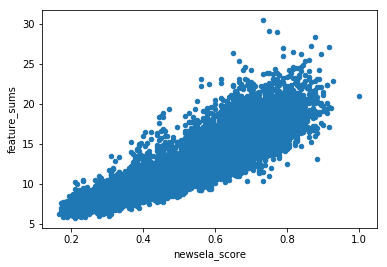

In [105]:
norm_df.plot.scatter(x="newsela_score",y="feature_sums")

In [106]:
norm_df.loc[norm_df["feature_sums"] > 30]

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
1443,data/clean_newsela/dog-brain-scan-21214-1320.txt,dog-brain-scan,21214,0.733333,0.887235,0.981307,1.076477,0.864928,0.909476,0.843771,...,1.747742,0.938436,0.400569,0.923324,11.325217,0.819879,0.487704,0.673113,0.918744,30.464172


## Apply Regression Model

* RidgeCV

In [107]:
norm_df = pd.read_csv("data/newsela_article_features.csv",sep=";")
norm_df["newsela_score"] = norm_df["newsela_score"].astype(float)

In [108]:
#feature_cols = norm_df.columns[2:-1]

In [109]:
def train_eval_model(train,test,model_fn):
    model = model_fn()
    
    feature_cols = list(train.columns)
    feature_cols.remove("newsela_score")
    
    model.fit(train[feature_cols],train["newsela_score"])
    
    print("Evaluation: \n Feature Importance:")
        
    for row in zip(*[train.columns,model.coef_]):
        print(row)
    print("Train Accuracy: ")
    print(model.score(train[feature_cols],
                    train["newsela_score"]))
    print("Test Accuracy: ")
    print(model.score(test[feature_cols],
                    test["newsela_score"]))
    
    return model

In [119]:
def eval_exclude_cols(df,feature_cols,exclude,test,model_fn):
    col_without = feature_cols
    bool_without = [col not in exclude for col in col_without]
    col_without = col_without[bool_without]
    #print(col_without,bool_without)
    train = df[["newsela_score"] + list(col_without)]
    
    return train_eval_model(
        train,test,model_fn)

In [111]:
y_bins = np.digitize(norm_df["newsela_score"], np.linspace(0,1,50))
y_bins[-1] = np.sort(y_bins)[-2]

In [112]:
#Test and Training Set
train,test = train_test_split(
    norm_df[["newsela_score"] + list(ts.feature_names)],
    stratify=y_bins,
    test_size=0.2,
    random_state=0)

R2 Coefficient: 0.9479588271526793


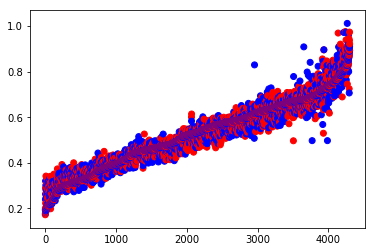

In [113]:
test_sorted = test.sort_values("newsela_score")
model = linear_model.RidgeCV()
model.fit(train[ts.feature_names],train["newsela_score"])
predictions = model.predict(test_sorted[ts.feature_names])
plt.scatter(
    x=[range(len(test)),range(len(test))],
    y=[predictions,test_sorted["newsela_score"]],
    c=["blue","red"])

print(f"R2 Coefficient: {model.score(test[ts.feature_names],test['newsela_score'])}")

In [114]:
model.predict(norm_df.loc[norm_df["name"] == "dog-brain-scan"][ts.feature_names])*1800

array([ 1451.80449097,   618.5584475 ,   845.79998379,   928.23096668,
        1149.66633801])

In [115]:
norm_df.loc[norm_df["name"] == "dog-brain-scan"]["newsela_score"]*1800

1443     1320.0
2244      550.0
9833      860.0
14546     980.0
18232    1170.0
Name: newsela_score, dtype: float64

### All Attributes

In [116]:
norm_df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,data/clean_newsela/nano-silver-2940-1030.txt,nano-silver,2940,0.572222,1.019529,0.586412,0.884826,0.581094,0.885181,0.673599,...,1.218640,0.483881,0.394310,0.959392,0.0,0.838109,0.640111,0.377311,0.516204,13.276822
1,data/clean_newsela/elem-robot-dog-funeral-japa...,elem-robot-dog-funeral-japan,42851,0.538889,0.915473,0.542635,0.899704,0.508872,0.900190,0.601939,...,0.672881,0.243993,1.345911,0.323163,0.0,0.397326,0.512089,0.441730,0.528593,11.684206
2,data/clean_newsela/public-schools-confederate-...,public-schools-confederate-names,34585,0.461111,0.984002,0.440245,0.892342,0.408791,0.794801,0.635107,...,0.764637,0.308343,1.201706,0.415496,0.0,0.454087,0.438934,0.323936,0.268072,10.105398
3,data/clean_newsela/food-waste-6332-490.txt,food-waste,6332,0.272222,0.806384,0.335052,1.263972,0.262201,0.877718,0.359253,...,0.794046,0.126328,0.000000,0.124294,0.0,0.382044,0.886308,0.130254,0.137231,8.378652
4,data/clean_newsela/scotus-jerusalem-10579-720.txt,scotus-jerusalem,10579,0.400000,0.942516,0.403098,1.179167,0.346986,0.667727,0.510010,...,0.819254,0.150820,0.150213,0.403954,0.0,0.567608,0.640111,0.305004,0.198222,9.145668


In [117]:
#RidgeCV
model = eval_exclude_cols(
    train,
    np.array(ts.feature_names),
    [],
    test,
    linear_model.RidgeCV
)

Evaluation: 
 Feature Importance:
('newsela_score', 0.53499063950384318)
('Mean word length', 0.66468051339651524)
('Mean sentence length', -0.11182349897183919)
('Basic english ratio', -0.62264077058928358)
('Syllables per sentence', -0.011821855735808739)
('Type token ratio', 0.13971210607998685)
('#nouns', 0.036327735225586189)
('#verbs', 0.037873026839487567)
('#adjectives', 0.027476062197337781)
('#adverbs', 0.002120131360122457)
('#pronouns', 0.054569405197157472)
('#commas', 0.065057839078454194)
('Subordination', 0.020485451025368917)
('Complements', 0.052390082862576293)
('Coordination', -0.0032943626159180894)
('Apposition', -0.0034667579983764796)
('Passive verbs', -0.00023973959259038224)
('Parataxis', 0.041918970378262088)
('Auxiliary Verbs', -0.0038956761764925574)
('Negation', 0.10420265318679789)
('Prepositional Phrases', 0.054680890275104588)
Train Accuracy: 
0.949519004291
Test Accuracy: 
0.947958827153


In [122]:
norm_df["regression_score"] = model.predict(norm_df[ts.feature_names])

In [128]:
norm_df[["path","feature_sums","regression_score"]+ts.feature_names].to_csv(
    "data/newsela_article_feature_scores.csv",
    sep=";",
    index=False)

### Weebit Data

In [113]:
weebit_df = pd.read_csv("data/weebit_articles_features.csv",sep=";")
weebit_df["regression_score"] = model.predict(weebit_df[ts.feature_names])
weebit_df["feature_sums"] = weebit_df[ts.feature_names].sum(axis=1)

In [114]:
weebit_df["group"] = [row[3] for row in weebit_df["path"].str.split("/")]

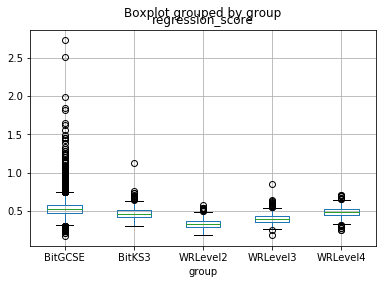

In [132]:
weebit_df.loc[
    (weebit_df["regression_score"] < 10)
].boxplot(column="regression_score",by="group")

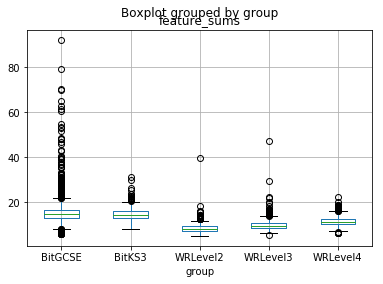

In [135]:
weebit_df.loc[
    #weebit_df["path"].str.contains("WRL") &
    (weebit_df["feature_sums"] < 100)].boxplot(column="feature_sums",by="group")

In [140]:
#which texts have a really high regression score?
high_value_df = weebit_df.loc[
    (weebit_df["regression_score"] > 1.5) &
    (weebit_df["regression_score"] < 2)]

In [142]:
for ind,row in high_value_df.iterrows():
    with open(row["path"],"r") as f:
        print(f.read())

Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Foundation
yourself on Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Higher
Addition, subtraction, multiplication and division - Higher
yourself on Addition, subtraction, multiplication and division - Higher
yourself on Converting fractions, decimals and percentages
yourself on Powers and roots - Foundation
yourself on Powers and roots - Higher

Moniza Alvi: Presents from my Aunts in Pakistan
Moniza Alvi: Presents from my Aunts in Pakistan
on Moniza Alvi: Presents from my Aunts in Pakistan
on Nissim Ezekiel: Night of the Scorpion
yourself on Nissim Ezekiel: Night of the Scorpion
Lawrence Ferlinghetti: Two Scavengers in a Truck...
Lawrence Ferlinghetti: Two Scavengers in a Truck...
on Lawrence Ferlinghetti: Two Scavengers in a Truck...
yourself on Lawrence Ferlinghetti: Two Scavengers in a Truck...
Suj

#### Exclude Articles with a score higher than 1.0

In [160]:
weebit_df = weebit_df.loc[
    (weebit_df["regression_score"] < 1.0)]

## Feature Correlation

### Plot Correlation Matrix

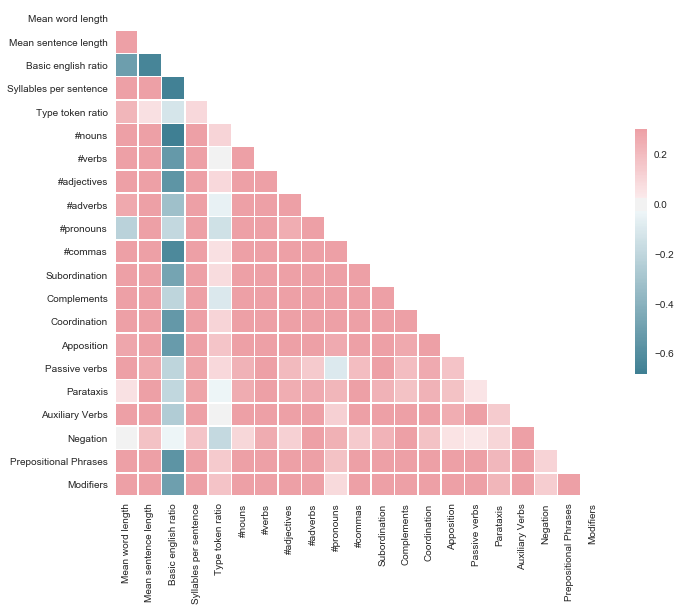

In [120]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = norm_df[ts.feature_names]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Save Scores for each text

In [161]:
final_weebit_df = weebit_df[["path"]+ts.feature_names]
final_newsela_df = norm_df[["path"]+ts.feature_names]


In [162]:
final_newsela_df["dataset"] = "newsela"
final_weebit_df["dataset"] = "weebit"



/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [164]:
dataset_df = pd.concat([final_newsela_df,final_weebit_df])
dataset_df.to_csv("data/dataset.csv",sep=";",index=False)

In [121]:
with open("models/ridgeCV.pkl","wb") as f:
    pickle.dump(model,f)

In [373]:
with open("models/ridgeCV.pkl","rb") as f:
    loaded_model = pickle.load(f)

In [374]:
loaded_model

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

## Check Dataset Values

In [180]:
for column in dataset_df.columns:
    print(f"NaN Rows in {column}: {sum(dataset_df[column].isna())}")
    if column in ts.feature_names:
        print(f"Finite Rows in {column}: {sum(~np.isfinite(dataset_df[column]))}")

NaN Rows in path: 0
NaN Rows in Mean word length: 0
Finite Rows in Mean word length: 0
NaN Rows in Mean sentence length: 0
Finite Rows in Mean sentence length: 0
NaN Rows in Basic english ratio: 0
Finite Rows in Basic english ratio: 0
NaN Rows in Syllables per sentence: 0
Finite Rows in Syllables per sentence: 0
NaN Rows in Type token ratio: 0
Finite Rows in Type token ratio: 0
NaN Rows in #nouns: 0
Finite Rows in #nouns: 0
NaN Rows in #verbs: 0
Finite Rows in #verbs: 0
NaN Rows in #adjectives: 0
Finite Rows in #adjectives: 0
NaN Rows in #adverbs: 0
Finite Rows in #adverbs: 0
NaN Rows in #pronouns: 0
Finite Rows in #pronouns: 0
NaN Rows in #commas: 0
Finite Rows in #commas: 0
NaN Rows in Subordination: 0
Finite Rows in Subordination: 0
NaN Rows in Complements: 0
Finite Rows in Complements: 0
NaN Rows in Coordination: 0
Finite Rows in Coordination: 0
NaN Rows in Apposition: 0
Finite Rows in Apposition: 0
NaN Rows in Passive verbs: 0
Finite Rows in Passive verbs: 0
NaN Rows in Parataxis: